In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sujalneupane","key":"ca045409a2dd40cbc9bfa3f5635ea40d"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! kaggle dataset list

usage: kaggle [-h] [-v] [-W] {competitions,c,datasets,d,kernels,k,models,m,files,f,config} ...
kaggle: error: argument command: invalid choice: 'dataset' (choose from 'competitions', 'c', 'datasets', 'd', 'kernels', 'k', 'models', 'm', 'files', 'f', 'config')


In [ ]:
!kaggle datasets download -d alincijov/self-driving-cars

Dataset URL: https://www.kaggle.com/datasets/alincijov/self-driving-cars
License(s): CC0-1.0
100% 889M/892M [00:13<00:00, 101MB/s] 
100% 892M/892M [00:13<00:00, 70.5MB/s]


In [ ]:
from zipfile import ZipFile

# Specify the path to the zip file
zip_file_path = '/content/self-driving-cars.zip'

# Specify the directory where you want to extract the files
extract_dir = '/content'

# Unzip the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report


In [ ]:
# Helper function to load and preprocess a single image
def load_and_preprocess_image(img_path, bbox, target_size=(224, 224)):
    img = cv2.imread(img_path)
    xmin, xmax, ymin, ymax = bbox

    # Plot the first 5 images with bounding boxes
    if load_and_preprocess_image.plot_counter < 5:
        img_annotated = cv2.rectangle(img.copy(), (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img_annotated, cv2.COLOR_BGR2RGB))
        plt.title(f'Bounding Box')
        plt.show()
        load_and_preprocess_image.plot_counter += 1

    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized / 255.0  # Normalize the image

    return img_normalized

load_and_preprocess_image.plot_counter = 0

In [ ]:
# Custom data generator
def data_generator(csv_file, images_dir, batch_size, target_size=(224, 224), num_classes=5):
    labels_df = pd.read_csv(csv_file)
    while True:
        for start in range(0, len(labels_df), batch_size):
            end = min(start + batch_size, len(labels_df))
            batch_df = labels_df[start:end]

            images = []
            labels = []

            for index, row in batch_df.iterrows():
                img_path = os.path.join(images_dir, row['frame'])
                bbox = (row['xmin'], row['xmax'], row['ymin'], row['ymax'])
                class_id = row['class_id'] - 1  # Adjust class_id to start from 0

                img = load_and_preprocess_image(img_path, bbox, target_size)

                images.append(img)
                labels.append(class_id)

            images = np.array(images)
            labels = tf.keras.utils.to_categorical(labels, num_classes)

            yield images, labels


In [ ]:
# Paths
images_dir = '/content/images'
train_csv = '/content/labels_train.csv'
trainval_csv = '/content/labels_trainval.csv'
test_csv = '/content/labels_val.csv'

# Parameters
batch_size = 32
num_classes = 5

# Generators
train_generator = data_generator(train_csv, images_dir, batch_size)
val_generator = data_generator(trainval_csv, images_dir, batch_size)

# Calculate steps per epoch
steps_per_epoch = len(pd.read_csv(train_csv)) // batch_size
validation_steps = len(pd.read_csv(trainval_csv)) // batch_size


In [ ]:
# Load ResNet50 model
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of ResNet
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


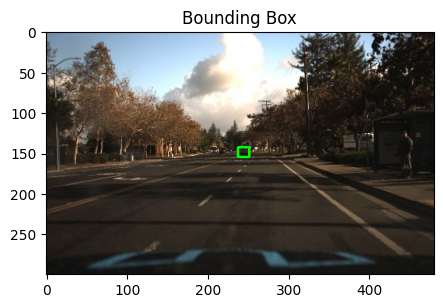

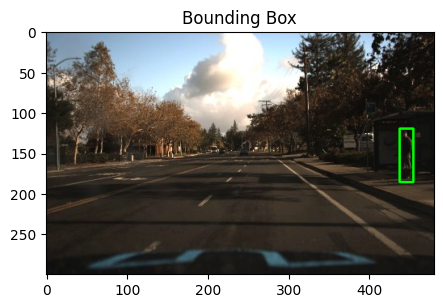

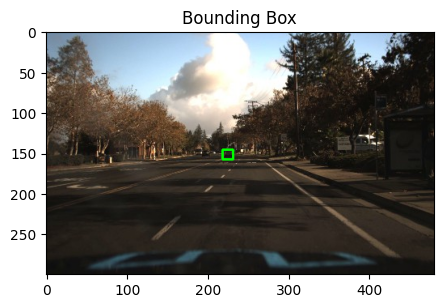

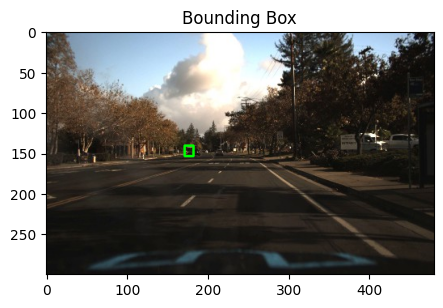

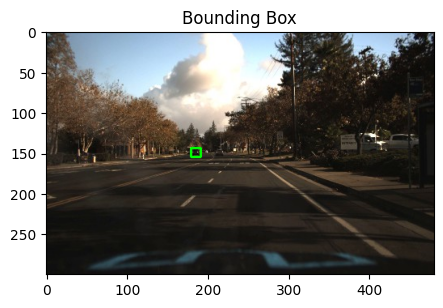

Epoch 1/4
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 1364s 326ms/step - accuracy: 0.6598 - loss: 0.9080 - val_accuracy: 0.7469 - val_loss: 1.4709
Epoch 2/4
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 1285s 309ms/step - accuracy: 0.6812 - loss: 0.9465 - val_accuracy: 0.7468 - val_loss: 1.4400
Epoch 3/4
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 1276s 309ms/step - accuracy: 0.6843 - loss: 0.9663 - val_accuracy: 0.7469 - val_loss: 1.5948
Epoch 4/4
4137/4137 ━━━━━━━━━━━━━━━━━━━━ 1275s 308ms/step - accuracy: 0.6875 - loss: 1.0091 - val_accuracy: 0.7469 - val_loss: 1.4152


In [ ]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=validation_steps,
                    epochs=4)


In [ ]:
# Save the model
model.save('/content/Resnet_transfer_learning.h5')

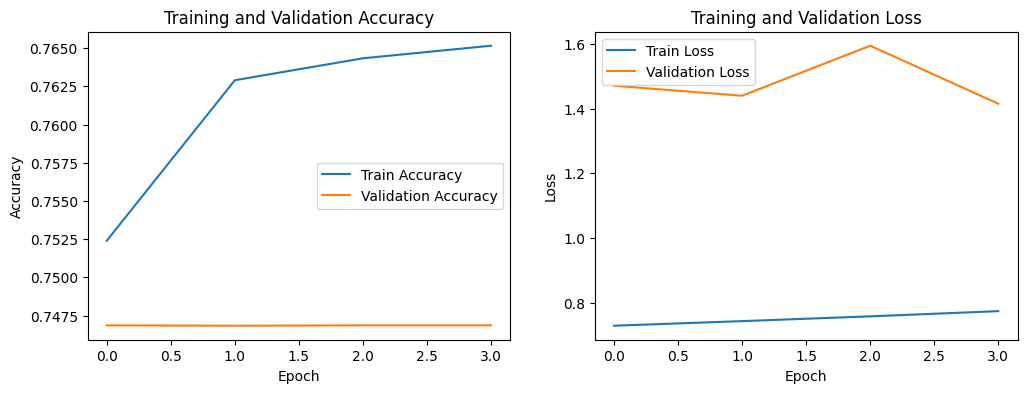

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,897,617 (114.05 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 4,206,604 (16.05 MB)

In [17]:
# Calculate Precision and Recall

# Get predictions for the validation set
val_labels = []
val_preds = []
for i in range(validation_steps):
    images, labels = next(val_generator)
    preds = model.predict(images)

    val_labels.extend(np.argmax(labels, axis=1))
    val_preds.extend(np.argmax(preds, axis=1))

# Generate classification report
print(classification_report(val_labels, val_preds, target_names=['car', 'truck', 'pedestrian', 'bicyclist', 'light']))




Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         car       0.75      1.00      0.86    123286
       truck       0.00      0.00      0.00      7320
  pedestrian       0.00      0.00      0.00     15538
   bicyclist       0.00      0.00      0.00      1676
       light       0.00      0.00      0.00     17253

    accuracy                           0.75    165073
   macro avg       0.15      0.20      0.17    165073
weighted avg       0.56      0.75      0.64    165073



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
